In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr
import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF
import harmonypy

def moe_correct_ridge(Z_orig, Z_cos, Z_corr, R, W, K, Phi_Rk, Phi_moe, lamb):
    Z_corr = Z_orig.copy()
    for i in range(K):
        Phi_Rk = np.multiply(Phi_moe, R[i,:])
        x = np.dot(Phi_Rk, Phi_moe.T) + lamb
        W = np.dot(np.dot(np.linalg.inv(x), Phi_Rk), Z_orig.T)
        W[0,:] = 0 # do not remove the intercept
        Z_corr -= np.dot(W.T, Phi_Rk)
    Z_cos = Z_corr / np.linalg.norm(Z_corr, ord=2, axis=0)
    return Z_cos, Z_corr, W, Phi_Rk


In [2]:
! pwd

/data/srlab1/dk718/Tcell_cNMF_Comparison/Analysis/HaoEtAl


In [3]:
sc.logging.print_versions()

-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.1
-----
PIL                         8.3.2
anndata                     0.7.6
anyio                       NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2021.10.08
cffi                        1.14.6
chardet                     4.0.0
charset_normalizer          2.0.0
cloudpickle                 2.0.0
cnmf                        NA
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.2
dask                        2021.11.2
dateutil                    2.8.2
debugpy                     1.4.1
decorator                   5.1.0
defusedxml                  0.7.1
entrypoints                 0.3
fastcluster                 1.1.26
fsspec                      2021.11.1
google            

# Parameters

In [4]:
mergefn = "../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.h5ad" # AnnData containing RNA +/- ADT
celltype_subset_col = 'celltype.l3.merged' # Set to None to do no filtering on cell type
celltypes_to_include = ['CD4', 'CD8', 'MAIT', 'gdT', 'dnT', 'Treg']
use_raw = True # Set to None if the adata.X field is already counts and you don't want to use adata.raw.X
filter_mito_thresh = None
RNA_normalize_targetsum = 1e4
n_top_rna_genes = 2000
n_top_adt_genes = 100
feature_type_col = 'feature_types' # Set to None if only RNA is included
adt_feature_name = 'Antibody Capture' # all other genes assumed to be RNA
min_cells_per_RNA_gene = 10
min_rna_counts_per_cell = 500
filter_mito_genes = False
max_scaled_thresh = None
harmony_vars = ['lane', 'donor']
n_neighbors = 30
n_rna_pcs = 31
n_adt_pcs = 21
name_addition = None # Set to a string if you want to append that to the name of saved files to run multiple versions of script

random_seed = 14

In [5]:
np.random.seed(random_seed)

# Set to raw, cell-type filter, split RNA and ADT

In [6]:
adata = sc.read(mergefn)

Only considering the two last: ['.T', '.h5ad'].
Only considering the two last: ['.T', '.h5ad'].


In [7]:
adata

AnnData object with n_obs × n_vars = 73259 × 20957
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'celltype.l3.merged'
    var: 'features', 'Clone', 'Specificity', 'feature_types'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'

In [8]:
if celltype_subset_col is not None:
    display(adata.obs[celltype_subset_col].value_counts())
    adata = adata[adata.obs[celltype_subset_col].isin(celltypes_to_include), :]

CD4     38494
CD8     25469
gdT      3649
MAIT     2784
Treg     2507
dnT       356
Name: celltype.l3.merged, dtype: int64

In [9]:
if use_raw:
    adata = sc.AnnData(adata.raw.X, var=adata.raw.var, obs=adata.obs)

In [10]:
if feature_type_col is not None:
    adata_ADT = adata[:,adata.var[feature_type_col]==adt_feature_name]
    adata_RNA = adata[:,adata.var[feature_type_col]!=adt_feature_name]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

In [11]:
adata_RNA

AnnData object with n_obs × n_vars = 73259 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'celltype.l3.merged'
    var: 'features', 'Clone', 'Specificity', 'feature_types', 'features_renamed'

# Process RNA

In [12]:
sc.pp.filter_genes(adata_RNA, min_cells=min_cells_per_RNA_gene)

In [13]:
sc.pp.filter_cells(adata_RNA, min_counts=min_rna_counts_per_cell)

Text(0.5, 1.0, 'log10 n_counts')

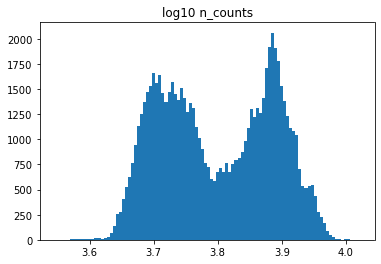

In [14]:
_ = plt.hist(adata_RNA.obs['n_counts'].apply(np.log10), bins=100)
plt.title('log10 n_counts')

In [15]:
mt_genes = [x for x in adata_RNA.var.index if 'MT-' in x]
dot_genes = [x for x in adata_RNA.var.index if '.' in x]

Text(0.5, 1.0, 'pct_mito')

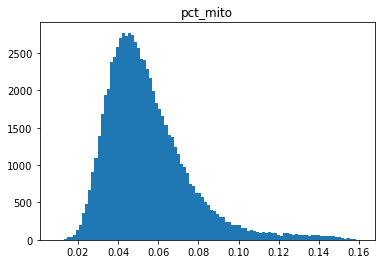

In [16]:
num_mito = np.array(adata_RNA[:,mt_genes].X.sum(axis=1)).reshape(-1)
pct_mito = num_mito / adata_RNA.obs['n_counts']
adata_RNA.obs['pct_mito'] = pct_mito

_ = plt.hist(adata_RNA.obs['pct_mito'], bins=100)
plt.title('pct_mito')

In [17]:
if filter_mito_thresh is not None:
    adata_RNA = adata_RNA[adata_RNA.obs['pct_mito'] < filter_mito_thresh, :]
    
adata_RNA

AnnData object with n_obs × n_vars = 73259 × 18038
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'celltype.l3.merged', 'n_counts', 'pct_mito'
    var: 'features', 'Clone', 'Specificity', 'feature_types', 'features_renamed', 'n_cells'

In [18]:


if filter_mito_genes:
    tofilter = mt_genes + dot_genes
else:
    tofilter = dot_genes

In [19]:
ind = ~adata_RNA.var.index.isin(tofilter)
adata_RNA = adata_RNA[:, ind]

In [20]:
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=n_top_rna_genes)

Trying to set attribute `.uns` of view, copying.


In [21]:
adata_RNA.raw = adata_RNA

In [22]:
sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=RNA_normalize_targetsum)

In [23]:
adata_RNA = adata_RNA[:, adata_RNA.var['highly_variable']]

In [24]:
sc.pp.scale(adata_RNA, zero_center=False, max_value=max_scaled_thresh)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


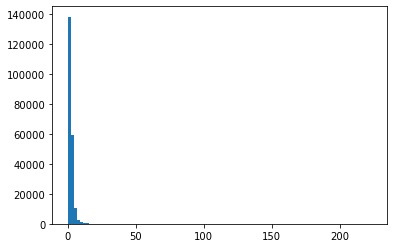

In [25]:
z = adata_RNA.X[:1000,:].todense()
y = np.array(z).reshape(-1)
_ = plt.hist(y[y>0], bins=100)
del(z)
del(y)

In [26]:
sc.pp.pca(adata_RNA, use_highly_variable=True, zero_center=True)

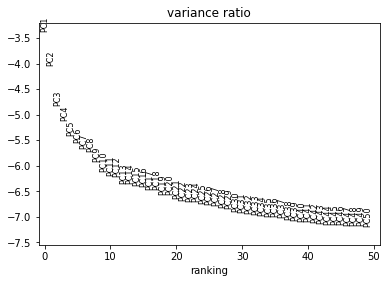

In [27]:
sc.pl.pca_variance_ratio(adata_RNA, log=True, n_pcs=50)

In [28]:
if harmony_vars is not None:
    harmony_res = harmonypy.run_harmony(adata_RNA.obsm['X_pca'], adata_RNA.obs,
                                    harmony_vars, max_iter_harmony = 20)
    adata_RNA.obsm['X_pca_harmony'] = harmony_res.Z_corr.T
else:
    adata_RNA.obsm['X_pca_harmony'] = adata_RNA.obsm['X_pca']
    

2022-06-05 14:26:15,458 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2022-06-05 14:26:47,512 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2022-06-05 14:27:19,991 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2022-06-05 14:27:52,676 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2022-06-05 14:28:20,345 - harmonypy - INFO - Iteration 5 of 20
Iteration 5 of 20
2022-06-05 14:28:33,945 - harmonypy - INFO - Iteration 6 of 20
Iteration 6 of 20
2022-06-05 14:28:47,691 - harmonypy - INFO - Converged after 6 iterations
Converged after 6 iterations


In [29]:
adata_RNA.obsm['X_pca_harmony'] = harmony_res.Z_corr.T

In [30]:
sc.pp.neighbors(adata_RNA, use_rep='X_pca_harmony', n_neighbors=n_neighbors, n_pcs=n_rna_pcs)

In [31]:
sc.tl.umap(adata_RNA)

In [32]:
adata_RNA.obsm['X_umap_RNA_Harmony'] = adata_RNA.obsm['X_umap']

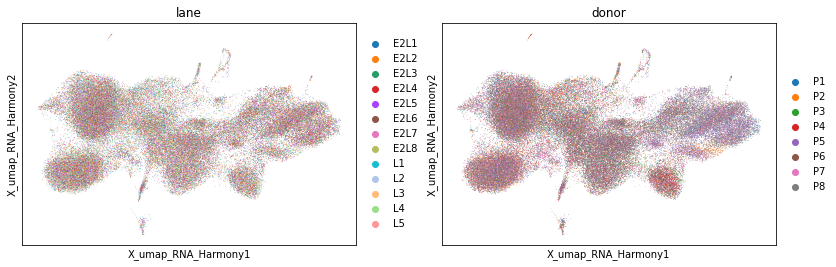

In [33]:
sc.pl.embedding(adata_RNA, basis='X_umap_RNA_Harmony', color=harmony_vars)

In [34]:
sc.tl.leiden(adata_RNA, resolution=2.0)

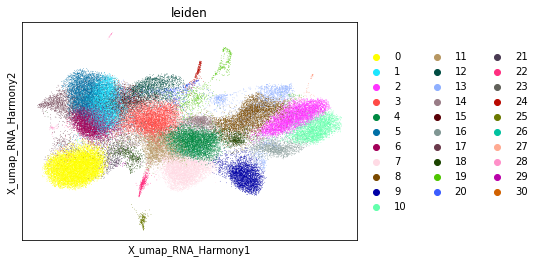

In [35]:
sc.pl.embedding(adata_RNA, basis='X_umap_RNA_Harmony', color=['leiden'])

In [36]:
if name_addition is not None:
    outfn = mergefn.replace('.h5ad', '.%s.RNA.TP10K.VarNorm.HVG.h5ad' % name_addition)
else:
    outfn = mergefn.replace('.h5ad', '.RNA.TP10K.VarNorm.HVG.h5ad')
    
outfn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.RNA.TP10K.VarNorm.HVG.h5ad'

In [37]:
sc.write(outfn, adata_RNA)

Only considering the two last: ['.HVG', '.h5ad'].
Only considering the two last: ['.HVG', '.h5ad'].


In [38]:
Z = sc.AnnData(adata_RNA.raw.X, obs=adata_RNA.obs, var=adata_RNA.raw.var)
Z = Z[:,adata_RNA.var.index]
sc.pp.scale(Z, zero_center=False)
X = np.array(Z.X.copy().todense())
del(Z)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [39]:
_, X_corr, _, _ = moe_correct_ridge(X.T, None, None, harmony_res.R, None, harmony_res.K,
                                            None, harmony_res.Phi_moe, harmony_res.lamb)
X_corr = X_corr.T

In [40]:
adata_RNA_corrected = adata_RNA.copy()

In [41]:
adata_RNA_corrected.X = X_corr

In [42]:
adata_RNA_corrected.X[adata_RNA_corrected.X<0] = 0

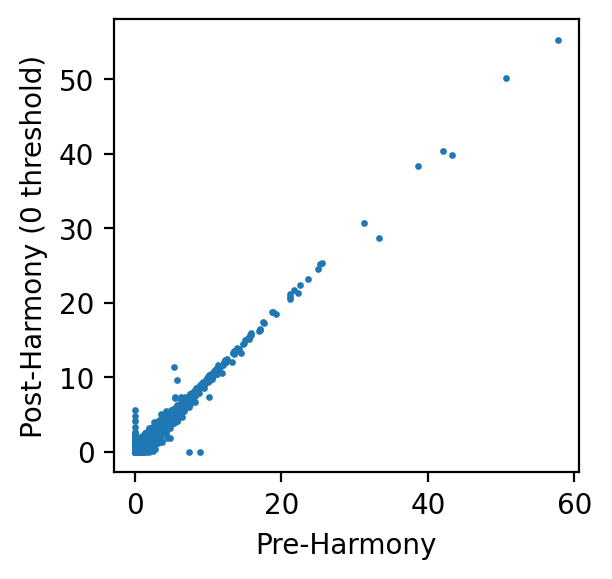

In [43]:
a = X.reshape(-1)
b = X_corr.reshape(-1)
ind = np.random.choice(a.shape[0], size=100000)
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(a[ind], b[ind], s=2)
ax.set_xlabel('Pre-Harmony')
ax.set_ylabel('Post-Harmony (0 threshold)')
del(a)
del(b)

In [44]:
if name_addition is not None:
    outfn = mergefn.replace('.h5ad', '.%s.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad' % name_addition)
else:
    outfn = mergefn.replace('.h5ad', '.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
outfn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [45]:
sc.write(outfn, adata_RNA_corrected)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [46]:
if name_addition is not None:
    rna_hvg_fn = mergefn.replace('.h5ad', '.%s.RNA.HVGlist.tsv' % name_addition)
    
else:
    rna_hvg_fn = mergefn.replace('.h5ad', '.RNA.HVGlist.tsv')
rna_hvg_fn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.RNA.HVGlist.tsv'

In [47]:
hvgs = list(adata_RNA_corrected.var.index[adata_RNA_corrected.var['highly_variable']])
open(rna_hvg_fn, 'w').write('\n'.join(hvgs))

12963

In [ ]:
## Output RNA only TP10K file if no ADT
if feature_type_col is None:
    adata_RNA_norm = sc.AnnData(X=adata_RNA.raw.X, obs=adata_RNA.obs, var=adata_RNA.raw.var)
    sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=RNA_normalize_targetsum)
    if name_addition is not None:
        outfn = mergefn.replace('.h5ad', '.%s.RNA.TP10K.h5ad' % name_addition)
    else:
        outfn = mergefn.replace('.h5ad', '.RNA.TP10K.h5ad')
    print(outfn)

# Get informative ADTs

In [48]:
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

In [49]:
adata_ADT.raw = adata_ADT.copy()

In [50]:
sc.pp.normalize_per_cell(adata_ADT)

In [51]:
sc.pp.scale(adata_ADT, zero_center=False)

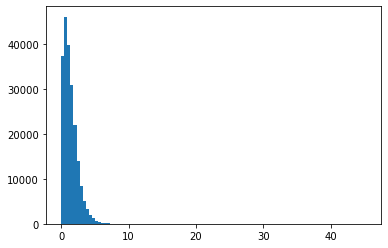

In [52]:
z = adata_ADT.X[:1000,:].todense()
y = np.array(z).reshape(-1)
_ = plt.hist(y[y>0], bins=100)
del(z)
del(y)

In [53]:
adata_ADT

AnnData object with n_obs × n_vars = 73259 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'celltype.l3.merged', 'n_counts'
    var: 'features', 'Clone', 'Specificity', 'feature_types', 'features_renamed', 'mean', 'std'

In [54]:
adata_ADT.obs['leiden_RNA'] = adata_RNA.obs.loc[adata_ADT.obs.index, 'leiden'].astype(str)

In [55]:
adata_ADT.X = adata_ADT.X.todense()

In [56]:
res = mutual_info_classif(adata_ADT.X, adata_ADT.obs['leiden_RNA'], discrete_features='auto',
                    n_neighbors=3, copy=True, random_state=None)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [57]:
res = pd.Series(res, index=adata_ADT.var.index)
res = res.sort_values(ascending=False)
resdf = pd.DataFrame([res.values, np.arange(res.shape[0])], columns=res.index, index=['MI', 'Rank']).T
resdf['MI_diff'] = resdf['MI'].diff()
resdf.head(50)

,MI,Rank,MI_diff
AB_CD4-1,0.502362,0.0,NaN
AB_CD8a,0.483703,1.0,-0.018660
AB_CD4-2,0.481871,2.0,-0.001831
AB_CD109,0.462016,3.0,-0.019855
AB_CD8,0.461797,4.0,-0.000219
AB_CD45RA,0.436123,5.0,-0.025674
AB_CD27,0.431915,6.0,-0.004208
AB_CD28,0.425995,7.0,-0.005920
AB_CD314,0.416032,8.0,-0.009963
AB_CD18,0.411483,9.0,-0.004549


In [58]:
resdf.tail(50)

,MI,Rank,MI_diff
AB_CD284,0.017159,178.0,-0.000016
AB_CD98,0.017147,179.0,-0.000011
AB_CD204,0.017127,180.0,-0.000021
AB_Galectin-9,0.017117,181.0,-0.000009
AB_CD164,0.016985,182.0,-0.000132
AB_CD62E,0.016965,183.0,-0.000020
AB_CD303,0.016862,184.0,-0.000103
AB_CD138-2,0.016793,185.0,-0.000069
AB_CD14,0.016740,186.0,-0.000053
AB_CD301,0.016642,187.0,-0.000097


(-0.02511812027419338, 0.5274805257580609)

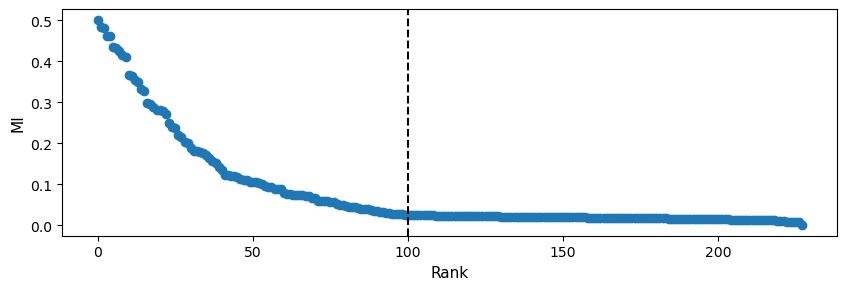

In [59]:
(fig,ax) = plt.subplots(1,1, figsize=(10,3), dpi=100)
ax.scatter(resdf['Rank'], resdf['MI'])
ax.set_ylabel('MI', fontsize=11)
ax.set_xlabel('Rank', fontsize=11)
offset=4

'''
for g in ['AB_CD28', 'AB_CD4', 'AB_CD8', 'AB_CD45RA', 'AB_CD27', 'AB_CD45RO']:
    ax.text(resdf.loc[g,'Rank']+offset, resdf.loc[g,'MI'], g, va='center', ha='left', fontsize=7)
        
offset = .02
for g in ['AB_Mouse IgG1_K_Iso', 'AB_Mouse_IgG2a_K_Iso', 'AB_Mouse_IgG2b_K_Iso']:
    ax.text(resdf.loc[g,'Rank'], resdf.loc[g,'MI']+offset, g, va='bottom', ha='center', fontsize=7, rotation=90)
'''

ylim = ax.get_ylim()
ax.vlines(x=n_top_adt_genes, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k')
ax.set_ylim(ylim)

In [60]:
if name_addition is not None:
    mifn = mergefn.replace('.h5ad', '.%s.ADT.TP10K.VarNorm.leidenRNA_MI.tsv' % name_addition)
else:
    mifn = mergefn.replace('.h5ad', '.ADT.TP10K.VarNorm.leidenRNA_MI.tsv')

mifn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.ADT.TP10K.VarNorm.leidenRNA_MI.tsv'

In [61]:
resdf.to_csv(mifn, sep='\t', index=True)


In [62]:
resdf = pd.read_csv(mifn, sep='\t', index_col=0)
resdf.head()

,MI,Rank,MI_diff
AB_CD4-1,0.502362,0.0,NaN
AB_CD8a,0.483703,1.0,-0.018660
AB_CD4-2,0.481871,2.0,-0.001831
AB_CD109,0.462016,3.0,-0.019855
AB_CD8,0.461797,4.0,-0.000219


In [63]:
resdf.head(50)

,MI,Rank,MI_diff
AB_CD4-1,0.502362,0.0,NaN
AB_CD8a,0.483703,1.0,-0.018660
AB_CD4-2,0.481871,2.0,-0.001831
AB_CD109,0.462016,3.0,-0.019855
AB_CD8,0.461797,4.0,-0.000219
AB_CD45RA,0.436123,5.0,-0.025674
AB_CD27,0.431915,6.0,-0.004208
AB_CD28,0.425995,7.0,-0.005920
AB_CD314,0.416032,8.0,-0.009963
AB_CD18,0.411483,9.0,-0.004549


In [64]:
resdf.head(100).tail(50)

,MI,Rank,MI_diff
AB_CD106,0.106739,50.0,-0.000215
AB_CD56-1,0.105201,51.0,-0.001537
AB_CD126,0.103671,52.0,-0.001530
AB_CD279,0.100859,53.0,-0.002813
AB_CD49a,0.096726,54.0,-0.004133
AB_CD226,0.093210,55.0,-0.003516
AB_CD96,0.092789,56.0,-0.000421
AB_CD45-2,0.089553,57.0,-0.003236
AB_TCR-V-2,0.088455,58.0,-0.001097
AB_CD47,0.088252,59.0,-0.000203


In [65]:
adata_ADT.var['MI'] = resdf.loc[adata_ADT.var.index, 'MI']
adata_ADT.var['MI_Rank'] = resdf.loc[adata_ADT.var.index, 'Rank']

In [66]:
adata_ADT.var['highly_variable'] = adata_ADT.var['MI_Rank']<n_top_adt_genes

In [67]:
adata_ADT.var['highly_variable'].value_counts()

False    128
True     100
Name: highly_variable, dtype: int64

In [68]:
adata_ADT_raw = sc.AnnData(X=adata_ADT.raw.X, obs=adata_ADT.obs, var=adata_ADT.var)


In [69]:
adata_ADT.raw = adata_ADT_raw

In [70]:
del(adata_ADT_raw)

In [71]:
adata_ADT = adata_ADT[:, adata_ADT.var['highly_variable']]

In [72]:
if name_addition is not None:
    outfn = mergefn.replace('.h5ad', '.%s.ADT.TP10K.VarNorm.HVG.h5ad' % name_addition)
else:
    outfn = mergefn.replace('.h5ad', '.ADT.TP10K.VarNorm.HVG.h5ad')
    
outfn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.ADT.TP10K.VarNorm.HVG.h5ad'

In [73]:
sc.write(outfn, adata_ADT)

Only considering the two last: ['.HVG', '.h5ad'].
Only considering the two last: ['.HVG', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_RNA' as categorical


# Output a merged TP10K and HVG file

In [74]:
adata_ADT = sc.AnnData(X=adata_ADT.raw.X, obs=adata_ADT.obs, var=adata_ADT.raw.var, raw=adata_ADT.raw)
adata_ADT = adata_ADT[:, adata_ADT.var['highly_variable']]

In [75]:
sc.pp.normalize_per_cell(adata_ADT, counts_per_cell_after=RNA_normalize_targetsum)

Trying to set attribute `.obs` of view, copying.


In [76]:
adata_RNA_norm = sc.AnnData(X=adata_RNA.raw.X, obs=adata_RNA.obs, var=adata_RNA.raw.var)
sc.pp.normalize_per_cell(adata_RNA_norm, counts_per_cell_after=RNA_normalize_targetsum)

In [77]:
merge_var = pd.concat([adata_RNA_norm.var[[feature_type_col, 'highly_variable']],
           adata_ADT.var[[feature_type_col, 'highly_variable']]], axis=0)

In [78]:
merge_X = hstack((adata_RNA_norm.X, adata_ADT.X))

In [79]:
merge_norm_adata = sc.AnnData(X=merge_X, obs=adata_RNA_norm.obs, var=merge_var)

In [80]:
merge_norm_adata.X = sparse.csr_matrix(merge_norm_adata.X)

In [81]:
if name_addition is not None:
    outfn = mergefn.replace('.h5ad', '.%s.RNA_and_ADT.TP10K.h5ad' % name_addition)
else:
    outfn = mergefn.replace('.h5ad', '.RNA_and_ADT.TP10K.h5ad')
outfn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.RNA_and_ADT.TP10K.h5ad'

In [82]:
sc.write(outfn, merge_norm_adata)

Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


In [84]:
if name_addition is not None:
    hvgfn = mergefn.replace('.h5ad', '.%s.RNA_and_ADT.HVGlist.tsv' % name_addition)
    
else:
    hvgfn = mergefn.replace('.h5ad', '.RNA_and_ADT.HVGlist.tsv')
hvgfn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.RNA_and_ADT.HVGlist.tsv'

In [85]:
hvgs = list(merge_norm_adata.var.index[merge_norm_adata.var['highly_variable']])
open(hvgfn, 'w').write('\n'.join(hvgs))

13868

In [86]:
if name_addition is not None:
    hvgfn = mergefn.replace('.h5ad', '.%s.RNA.HVGlist.tsv' % name_addition)
    
else:
    hvgfn = mergefn.replace('.h5ad', '.RNA.HVGlist.tsv')
hvgfn

'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.RNA.HVGlist.tsv'

# Harmonize ADT

In [87]:
sc.pp.scale(adata_ADT, zero_center=False, max_value=max_scaled_thresh)

In [88]:
sc.pp.pca(adata_ADT, zero_center=True, use_highly_variable=True)

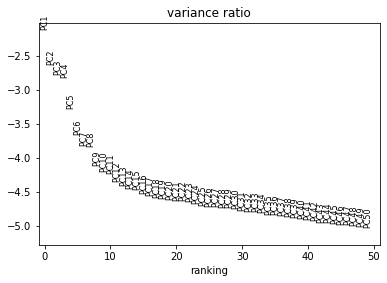

In [89]:
sc.pl.pca_variance_ratio(adata_ADT, log=True, n_pcs=50)

In [90]:
adata_ADT.obs.columns

Index(['nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA',
       'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT',
       'celltype.l3.merged', 'n_counts', 'leiden_RNA'],
      dtype='object')

In [91]:
harmony_res = harmonypy.run_harmony(adata_ADT.obsm['X_pca'][:,:n_adt_pcs], adata_ADT.obs,
                                    harmony_vars, max_iter_harmony = 20)

2022-06-05 14:38:37,708 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2022-06-05 14:39:08,404 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2022-06-05 14:39:39,069 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2022-06-05 14:40:09,773 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2022-06-05 14:40:40,445 - harmonypy - INFO - Iteration 5 of 20
Iteration 5 of 20
2022-06-05 14:41:10,077 - harmonypy - INFO - Iteration 6 of 20
Iteration 6 of 20
2022-06-05 14:41:29,877 - harmonypy - INFO - Iteration 7 of 20
Iteration 7 of 20
2022-06-05 14:41:46,773 - harmonypy - INFO - Iteration 8 of 20
Iteration 8 of 20
2022-06-05 14:42:00,625 - harmonypy - INFO - Iteration 9 of 20
Iteration 9 of 20
2022-06-05 14:42:13,202 - harmonypy - INFO - Iteration 10 of 20
Iteration 10 of 20
2022-06-05 14:42:24,359 - harmonypy - INFO - Converged after 10 iterations
Converged after 10 iterations


In [92]:
adata_ADT.obsm['X_pca_harmony'] = harmony_res.Z_corr.T

In [93]:
sc.pp.neighbors(adata_ADT, n_pcs=n_adt_pcs, use_rep='X_pca_harmony')

In [94]:
sc.tl.umap(adata_ADT)

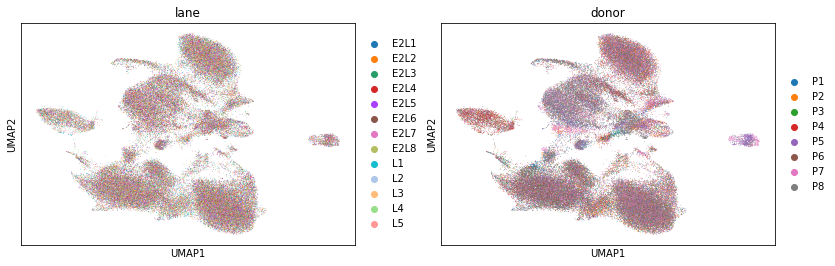

In [95]:
sc.pl.umap(adata_ADT, color=harmony_vars)

In [96]:
Z = sc.AnnData(adata_ADT.raw.X, obs=adata_ADT.obs, var=adata_ADT.raw.var)
Z = Z[:,adata_ADT.var.index]
sc.pp.scale(Z, zero_center=False)
X = np.array(Z.X.copy().todense())
del(Z)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [97]:
_, X_corr, _, _ = moe_correct_ridge(X.T, None, None, harmony_res.R, None, harmony_res.K,
                                            None, harmony_res.Phi_moe, harmony_res.lamb)
X_corr = X_corr.T

In [98]:
adata_ADT_corrected = adata_ADT.copy()

In [99]:
adata_ADT_corrected.X = X_corr

In [100]:
adata_ADT_corrected.X[adata_ADT_corrected.X<0] = 0

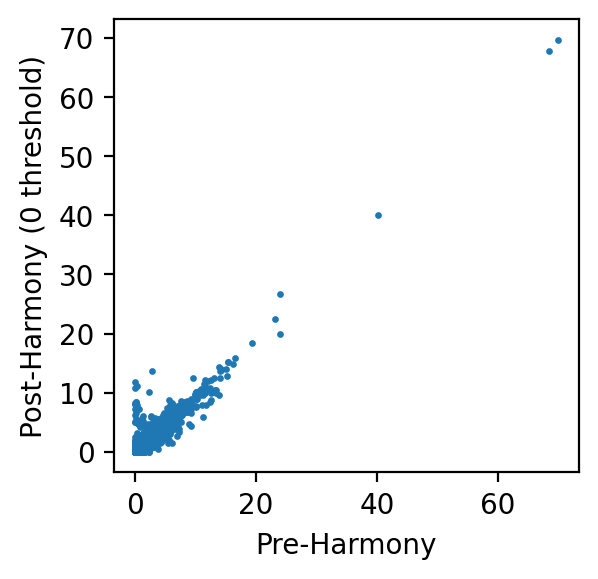

In [101]:
a = X.reshape(-1)
b = X_corr.reshape(-1)
ind = np.random.choice(a.shape[0], size=100000)
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(a[ind], b[ind], s=2)
ax.set_xlabel('Pre-Harmony')
ax.set_ylabel('Post-Harmony (0 threshold)')
del(a)
del(b)

# Prepare merged corrected file

In [102]:
merge_X = np.concatenate((adata_RNA_corrected.X, adata_ADT_corrected.X), axis=1)

In [103]:
merge_X.shape

(73259, 2100)

In [107]:
merge_var = pd.concat([adata_RNA_corrected.var, adata_ADT_corrected.var], axis=0)

In [108]:
merge_corrected_adata = sc.AnnData(X=merge_X, obs=adata_RNA_norm.obs, var=merge_var)


In [109]:
if name_addition is not None:
    outfn = mergefn.replace('.h5ad', '.%s.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad' % name_addition)
else:
    outfn = mergefn.replace('.h5ad', '.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
outfn



'../../Data/HaoEtAl_PBMC/haoetal_pbmc_multimodal.merged.T.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [110]:
sc.write(outfn, merge_corrected_adata)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Clone' as categorical
/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Specificity' as categorical
/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprec